In [1]:
# Python script to estimate the STARS foam model parameter from experimental data. 
# This is a python adoption of a Julia script written by A.A. Eftekhari, see https://github.com/simulkade/foamparameters. 


In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import nlopt
from Relperm import *
from FoamModel import *
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [3]:
data = pd.DataFrame(columns=['fg_exp','mu_exp','mu_water','mu_gas','u_exp','sw_exp'])
data['fg_exp']=[0.11142,
0.22251,
0.33109,
0.43742,
0.54062,
0.63953,
0.73413,
0.8256,
0.90929,
0.95256]

data['mu_exp'] = [0.74646,
0.82715,
0.87918,
0.93386,
0.97559,
1.0292,
1.0814,
1.1136,
0.91593,
0.36635]

data['u_exp'] = [1.4885E-05,
1.5121E-05,
1.5379E-05,
1.5673E-05,
1.5995E-05,
1.6307E-05,
1.6582E-05,
1.6853E-05,
1.62E-05,
1.5489E-05]

data['mu_water'] = np.ones(len(data))*1e-3

data['mu_gas'] = np.ones(len(data))*2e-05

# data['u_exp'] = np.ones(len(data))*2.89e-6

sigma_wg = 0.03 
muw = data['mu_water'].iloc[0]
mug = data['mu_gas'].iloc[0]

In [4]:
# Relperm data
swc = 0.05                                                                     # connate water saturation [-]
sgr = 0.03                                                                     # irreducable gas saturation [-]
nw = 4.423                                                                     # Corey water exponent [-]
ng = 0.938                                                                     # Corey gas exponent [-]
krg0 = 0.587                                                                   # endpoint gas relative permeability [-]
krw0 = 0.720

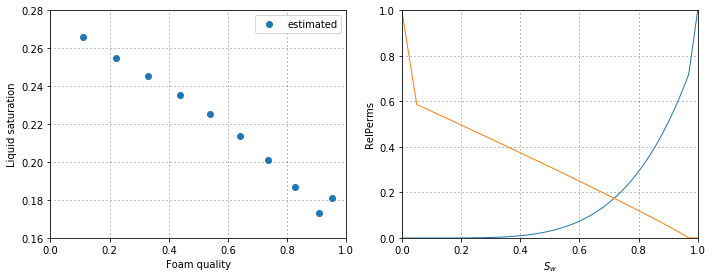

In [5]:
sw_plt = np.linspace(0.0,1.0, 100)
sw_plt = sw_plt.reshape([len(sw_plt),1])

data['sw_exp'] = (1-swc-sgr)*(data['mu_water']*(1-data['fg_exp'])/(krw0*data['mu_exp']))**(1/nw)+swc
sw_exp = data['sw_exp'].values.reshape([len(data['sw_exp'] ),1])

krg_plt = krg(sw_plt, swc, sgr, krg0, ng)
krw_plt = krw(sw_plt, swc, sgr, krw0, nw)

plt.figure(1, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(data['fg_exp'], data['sw_exp'], "o")
plt.xlabel("Foam quality")
plt.ylabel("Liquid saturation")
plt.legend(["estimated"])
plt.grid()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(sw_plt, krw_plt, sw_plt, krg_plt)
plt.xlabel(r"$S_w$")
plt.ylabel("RelPerms")
plt.grid()
plt.tight_layout()

In [6]:
transition = pd.DataFrame(np.nan,np.arange(1),columns=['trans_ind','fg_trans','mu_trans'])

# transition fron low- to high-quality
transition['trans_ind'] = data['mu_exp'].idxmax(axis=0, skipna=True)
transition['fg_trans']  = data['fg_exp'].iloc[transition['trans_ind'].iloc[0]]
transition['mu_trans']  = data['mu_exp'].iloc[transition['trans_ind'].iloc[0]]

sw_trans = (1-swc-sgr)*(data['mu_water'].iloc[transition['trans_ind'].iloc[0]]* \
                        (1-transition['fg_trans'].iloc[0])/(krw0*transition['mu_trans'].iloc[0]))**(1/nw)+swc

In [7]:
# Initial guess and bound constraints for least square parameter estimation
x0 = np.array([2.3e5,10000,0.17,1e-4 ,2.5,1])
# x0 = np.array([1e4, 1e4, 0.15, 0.001, 1.5])
# bound = ([10,10,swc,1e-4,0] , [1e8,1e5,sw_trans+0.05,1e-2,4])

lb                = [10,10,swc,1e-4,2.26,1e-4]                            
ub                = [1e8,1e5,sw_trans+0.05,1e-3,4,4];      
bound =[lb,ub]

w = np.ones((np.size(sw_exp), 1))

w[transition['trans_ind'].iloc[0]-3:transition['trans_ind'].iloc[0]-1] = 5e8
w[transition['trans_ind'].iloc[0]:transition['trans_ind'].iloc[0]+2] = 3e6

csurf = 1.1
fmsurf= 2

In [8]:
# Least square 
labdaw = krw(sw_exp, swc, sgr, krw0, nw)/data['mu_water'].values.reshape(len(data['mu_water']),1)                                                 # water mobility
labdag = krg(sw_exp, swc, sgr, krg0, ng)/data['mu_gas'].values.reshape(len(data['mu_gas']),1)                    

muf_exp = data['mu_exp'].values.reshape([len(data['mu_exp']),1])
u_exp = data['u_exp'].values.reshape([len(data['u_exp']),1])


# def misfit(x):
#     return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
#                                            (x[3]/(u_exp*muf_exp/sigma_wg))**x[4])))/muf_exp)**2)

def misfit(x):
    return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*
                                           (0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
                                           (x[3]/(u_exp*muf_exp/sigma_wg))**x[4]*
                                           (csurf/fmsurf)**x[5])))/muf_exp)**2)



es = optimize.least_squares(misfit, x0, bounds=bound)

foam_param = np.zeros((5, 0))
foam_param = es.x
foam_param = np.reshape(foam_param, (len(foam_param), 1))
param_ls = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_ls['fmmob'] = foam_param[0, 0]
param_ls['epdry'] = foam_param[1, 0]
param_ls['fmdry'] = foam_param[2, 0]
param_ls['fmcap'] = foam_param[3, 0]
param_ls['epcap'] = foam_param[4, 0]
param_ls['epsurf'] = foam_param[5, 0]
print(param_ls)


           fmmob         epdry     fmdry     fmcap     epcap    epsurf
0  623671.162598  10033.916948  0.154953  0.000234  2.521606  0.966059


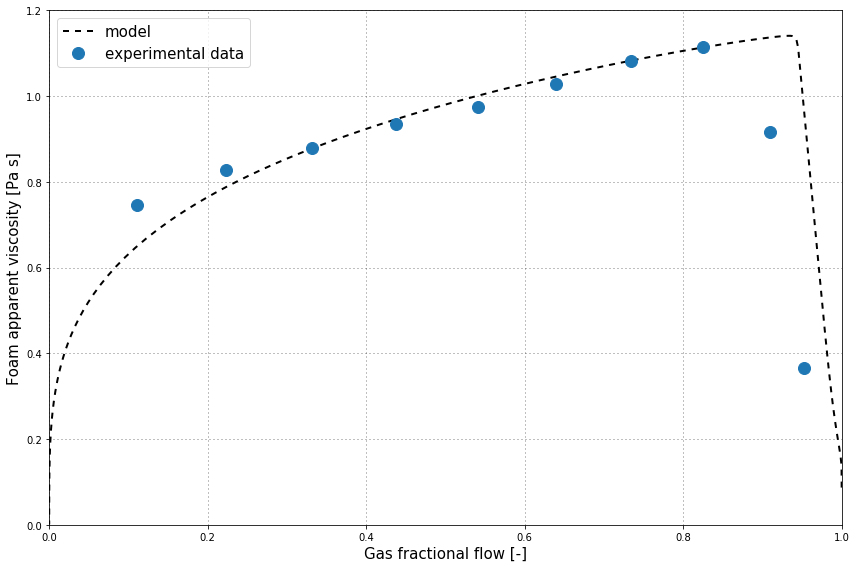

In [11]:
# Fit visualization
sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 300),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 300))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 300))

n1 = np.size(sw_val)
muf_opt = np.zeros((n1, 1))
u_min = np.min(data['u_exp'])
u_max = np.max(data['u_exp'])
u_ave = float(np.mean(data['u_exp']))

F12 = [fmsurf, foam_param[5, 0]]
F22 = [foam_param[0, 0], foam_param[1, 0], foam_param[2, 0]]
F52 = [foam_param[3, 0], foam_param[4, 0]]

r = 0
for s in sw_val:
    ss = np.ndarray(shape = (1,),dtype=float)
    ss[0] = s
    def fmu2(x):
        return float(x - muf_mod_f1f2f5(ss, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[r, 0] = sol.x
    r = r + 1


fg_opt = fg_mod_f1f2f5(sw_val, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f1f2f5(sw_val, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, muf_opt, u_ave)

plt.figure(figsize=[12,8])
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2,label='model')
plt.plot(data['fg_exp'], data['mu_exp'], "o",markersize =12,label='experimental data')
plt.ylabel("Foam apparent viscosity [Pa s]",fontsize=15)
plt.xlabel("Gas fractional flow [-]",fontsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=15)

plt.show()



In [12]:
# optimization
localopt_feval_max = 50000
# x0 = np.array([2.3e5,10000.,0.19,1.5e-4,2.7])
# lb = np.array([100.,10.,0.19,1e-4,2.])
# ub = np.array([1e9,1e5,0.3,1e-3,3.])

def myfunc(x, grad):
     J = sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*
                                           (0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
                                           (x[3]/(u_exp*muf_exp/sigma_wg))**x[4]*
                                           (csurf/fmsurf)**x[5])))/muf_exp)**2)
#      J = sum(w*(muf_mod_f1f2f5(sw_exp, [fmsurf, x[0]], x[1:4], x[4:6], muf_exp, u_exp) - muf_exp)**2)
     return J[0]



opt = nlopt.opt(nlopt.LN_COBYLA, 6)
opt.set_maxeval(localopt_feval_max)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_min_objective(myfunc)
x = opt.optimize(x0)
minf = opt.last_optimum_value()

param_opt = pd.DataFrame(np.nan,np.arange(1),
                         columns = ['fmsurf','epsurf','fmmob','epdry','fmdry','fmcap','epcap'])

param_opt['fmsurf'] = fmsurf
param_opt['epsurf'] = x[5]
param_opt['fmmob'] = x[0]
param_opt['epdry'] = x[1]
param_opt['fmdry'] = x[2]
param_opt['fmcap'] = x[3]
param_opt['epcap'] = x[4]

print(param_opt)


   fmsurf    epsurf          fmmob         epdry     fmdry     fmcap     epcap
0       2  1.703737  473983.273958  18358.234751  0.173234  0.000312  2.584535


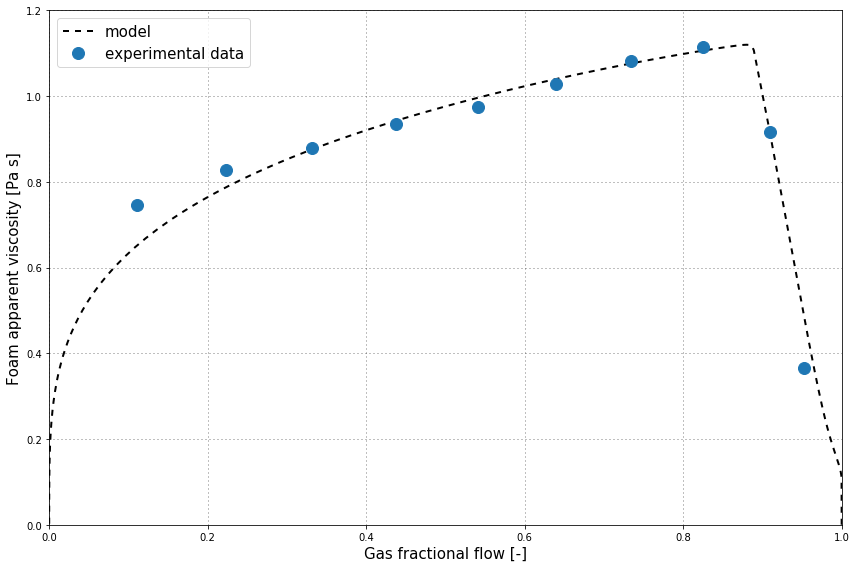

In [13]:
# Fit visualization
sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 300),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 300))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 300))

n1 = np.size(sw_val)
muf_opt = np.ndarray(shape = (n1,1), buffer = np.zeros((n1, 1)),
                     dtype= float)
u_min = np.min(data['u_exp'])
u_max = np.max(data['u_exp'])
u_ave = float(np.mean(data['u_exp']))

F12 = [fmsurf, x[5]]
F22 = [x[0], x[1], x[2]]
F52 = [x[3], x[4]]

r = 0
for s in sw_val:
    ss = np.ndarray(shape = (1,),dtype=float)
    ss[0] = s
    def fmu2(x):
        return float(x - muf_mod_f1f2f5(ss, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[r, 0] = sol.x
    r = r + 1


fg_opt = fg_mod_f1f2f5(sw_val, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f1f2f5(sw_val, swc, sgr, krw0, krg0, nw, ng, 
                               mug, muw, sigma_wg, csurf, F12, F22, F52, muf_opt, u_ave)

plt.figure(figsize=[12,8])
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2,label='model')
plt.plot(data['fg_exp'], data['mu_exp'], "o",markersize =12,label='experimental data')
plt.ylabel("Foam apparent viscosity [Pa s]",fontsize=15)
plt.xlabel("Gas fractional flow [-]",fontsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=15)

plt.show()



In [2]:
# def find_indices(vector, condition):
#     return [i for i, elem in enumerate(vector) if condition(elem)]


# def relative_sort(vector1, vector2):
#     return [x for _, x in sorted(zip(vector1, vector2))]

# ##########################$######################################

# def sws(s_w):
#     s_w = s_w.reshape([len(s_w),1])
#     s_ws = np.ndarray(shape=(len(s_w),1),
#                         buffer = np.zeros([len(s_w),1]),
#                         dtype = float)
#     b = ((s_w > swc) &  (s_w < (1-sgr))).astype(int)
#     c = (s_w>=(1-sgr)).astype(int)
#     s_ws = b * ((s_w-swc)/(1-sgr-swc)) + c * 1

#     return s_ws


# def krg(s_w):
#     s_w = s_w.reshape([len(s_w),1])
#     kr_g = np.ndarray(shape=(len(s_w),1),
#                         buffer = np.zeros([len(s_w),1]),
#                         dtype = float)
#     b = (s_w >= swc).astype(int)
#     c = (s_w<swc).astype(int)
#     kr_g = b * (krg0 * (1-sws(s_w)) ** ng) + c *(1+(krg0-1)/swc * s_w)
#     return kr_g



# def krw(s_w):
#     s_w = s_w.reshape([len(s_w),1])
#     kr_w = np.ndarray(shape=(len(s_w),1),
#                         buffer = np.zeros([len(s_w),1]),
#                         dtype = float)
#     b = (s_w <= (1 - sgr)).astype(int)
#     c = (s_w > (1 - sgr)).astype(int)
#     kr_w = b * (krw0 * sws(s_w) ** nw) + c * ((-(1 - krw0) / sgr * (1.0 - s_w) + 1.0))
#     return kr_w


# def dryout(x, sw):
#     return 0.5 + np.arctan(x[1]*(sw-x[2]))/np.pi


# def fm_mod_f2(s_w, f2):
#     s_w = s_w.reshape([len(s_w),1])
#     fm = 1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi)
#     return fm


# def fg_mod_f2(s_w, f2):
#     krf = (krg(s_w) / fm_mod_f2(s_w, f2))
#     fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
#     return fg


# def muf_mod_f2(s_w, f2):
#     krf = (krg(s_w) / fm_mod_f2(s_w, f2))
#     mu_foam = (1 / (krw(s_w) / muw + krf / mug))
#     return mu_foam


# def fm_mod_f2f5(s_w, f2, f5, mu_f, u_t):
#     s_w = s_w.reshape([len(s_w),1])
#     mu_f = mu_f.reshape([len(mu_f),1])
#     fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
#           (f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])
#     return fm


# def fg_mod_f2f5(s_w, f2, f5, mu_f, u_t):
#     krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
#     fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
#     return fg


# def muf_mod_f2f5(s_w, f2, f5, mu_f, u_t):
#     krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
#     mu_foam = (1 / (krw(s_w) / muw + krf / mug))
#     return mu_foam
# ########################################################################
# ########################################################################
# # seven parameter function (fmmob,epdry,fmdry,fmcap,epcap,csurf,fmsurf,epsurf)

# def fm_mod_f1f2f5(s_w, f1,f2, f5, mu_f, u_t):
#     s_w = s_w.reshape([len(s_w),1])
#     mu_f = np.reshape(mu_f, (np.size(mu_f), 1))
#     fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
#           ((f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])*(csurf/f1[0])**f1[1])
#     return fm

# def fg_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t):
#     krf = (krg(s_w) / fm_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t))
#     fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
#     return fg


# def muf_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t):
#     krf = (krg(s_w) / fm_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t))
#     mu_foam = (1 / (krw(s_w) / muw + krf / mug))
#     return mu_foam